# GCN Code

### Latex Macros
$\newcommand{\Re}[1]{{\mathbb{R}^{{#1}}}}
\newcommand{\Rez}{{\mathbb{R}}}$

# GNN_torch_edge_attrib_update_torch.ipynb (2022-03-07)
* Based on First_GNN_torch_implementation
* Eventually implement edge and graph embeddings in addition node embddings
* Continue to refacdtor the code
* Starting from First_GNN_torch_implementation.ipynb, transform it to a version using using aggregation and update operators. 
* This is message passing approach.
* The code will still handle the Karate Club Graph
* Use a function library just for the Karate Club Graph dataset. 
* This library will later be generalized to handle a wider set of data. 
* Eventually, we will use the PyGeometric, but there is lots to learn before that point. 
* I am adding edge attributes, which is synthetic. 
* [Torch tutorial](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)

In [1]:
%load_ext autoreload
%autoreload 2
#%tableofcontents

In [3]:
import torch
import torch.sparse as tsp
# help(torch.sparse)
from torch import tensor
import torch_sparse as t_sp
#from torchsummary import summary
import tqdm.auto
from tqdm import tqdm
import os
from collections import defaultdict
import spectral_function_library as speclib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import karate_function_library as karate

In [4]:
a = torch.zeros(3)
a.requires_grad

False

In [5]:
# Test sparse matrix
# https://pytorch.org/docs/stable/sparse.html
"""
 A =  1 0 5
      3 2 0
      
 B =  1 0 
      3 2
      0 3
"""
IA = tensor([0,0,1,1])
JA = tensor([0,2,0,1])
VA = tensor([1.,5.,3.,2.])
mA = 2
nA = 3
indexA = tensor([[0,0,1,1], [0,2,0,1]])

IB = tensor([0,1,1,2])
JB = tensor([0,0,1,1])
VB = tensor([1.,3.,2.,3.])
mB = 3
nB = 2
indexB = tensor([[0,1,1,2],[0,0,1,1]])

C = tensor([[2., 3.], [4., 5.]])  # 2,2

# Objective: multipley B @ C (Matrix-matrix multiplication)

# help(torch.sparse_coo_tensor)
# Supposedly, using CSR format is faster than COO format, on the CPU
# However, CSR has no GPU implementation
outA = torch.sparse_coo_tensor(indexA, VA, [mA, nA])
outB = torch.sparse_coo_tensor(indexB, VB, [mB, nB])

# out = torch.spspmm(indexA, VA, indexB, VB, mA, nA, nB)
IA.shape
denseA = outA.to_dense()
denseB = outB.to_dense()
print(denseA.shape, denseB.shape, C.shape)
print(denseB)

# Dense @ Sparse
#out = torch.mm(C, outA)  # not valid. Sparse matrices have no strides

BmmC = denseB @ C
print("B @ C = ", BmmC)  

# Sparse @ Dense (use tensor_sparse)
print("==============================")
out = t_sp.spmm(indexB, VB, mB, nB, C)
print("B @ C (spmm): ", out)
print("B @ C: ", denseB)

# Sparse @ Dense 
outBA = torch.mm(outB, C)
outBA = outB @ C
print("==> \n", "dense@sparse B@A: \n", outBA)
print("             B@A: \n", torch.mm(outB.to_dense(), C))

# Execute product of dense matrix and sparse matrix
# Not supported by torch


torch.Size([2, 3]) torch.Size([3, 2]) torch.Size([2, 2])
tensor([[1., 0.],
        [3., 2.],
        [0., 3.]])
B @ C =  tensor([[ 2.,  3.],
        [14., 19.],
        [12., 15.]])
B @ C (spmm):  tensor([[ 2.,  3.],
        [14., 19.],
        [12., 15.]])
B @ C:  tensor([[1., 0.],
        [3., 2.],
        [0., 3.]])
==> 
 dense@sparse B@A: 
 tensor([[ 2.,  3.],
        [14., 19.],
        [12., 15.]])
             B@A: 
 tensor([[ 2.,  3.],
        [14., 19.],
        [12., 15.]])


In [6]:
### We use the famous 'Karate Club' network as a test case. Our task is to
### predict the community to which each node belongs; formally, this would be
### called transductive binary node classification.

G = nx.karate_club_graph()

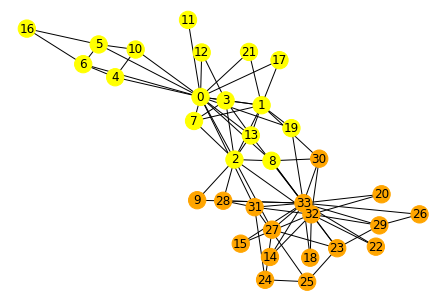

In [7]:
karate.drawOriginalGraph(G)

# Features

In [172]:
# add nb_features, node_metadata to G
karate.add_gaussian_features(G, node_means=[0.0, 1.5], node_stds=(1, 1), 
                             nb_node_features=16, nb_edge_features=8)
karate.update_associated_matrices(G)

tensor([17., 10., 11.,  7.,  4.,  5.,  5.,  5.,  6.,  3.,  4.,  2.,  3.,  6.,
         3.,  3.,  3.,  3.,  3.,  4.,  3.,  3.,  3.,  6.,  4.,  4.,  3.,  5.,
         4.,  5.,  5.,  7., 13., 18.])
G.B:  torch.Size([78, 34]) G.B.transp:  torch.Size([34, 78])


/Users/erlebach/src/2022/graphs/Advanced_Grad_Seminar_GNN/karate_function_library.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  G.An = torch.tensor(Dinvsq @ G.An @ G.Dinvsq).float() # symmetric normalization


# Plot Metadata histograms

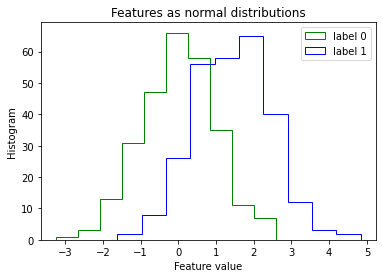

In [173]:
karate.plot_metadata(G)

# Linear model is 
$$ H^{n+1} = A H^n W $$
where $H\in \Re{N\times d}$, $A\in\Re{N\times N}$, and $W\in\Re{d\times d}$ and $d$ is the number of features. In our synthetic example, we have 16 features, one label. `

In [174]:
def set_weight(n_in, n_out):
    W = torch.zeros(n_in, n_out, dtype=torch.float, requires_grad=True)
    rmax = 1. / n_in ** 0.5
    torch.nn.init.uniform_(W, -rmax, rmax)
    W = torch.nn.Parameter(W)
    return W

In [196]:
class GNNNodesEdges(torch.nn.Module):
    # the graph G will contain the adjacency matrix A, and the node-edge matrix B and Btransp. 
    # Saving B and Btransp is inefficient but convenient
    def __init__(self, G):
        super(GNNNodesEdges, self).__init__()

        self.G = G
        self.d = self.nb_node_features = G.nb_node_features
        self.f = self.nb_edge_features = G.nb_edge_features
        self.B = G.B
        self.Btransp = G.Btransp
        self.DinvCoo = G.DinvCoo
   
        # self.relu1 = torch.nn.ReLU();
        # self.relu2 = torch.nn.ReLU();
        
        self.W0 = set_weight(self.f, self.f)
        self.W1 = set_weight(self.d, self.f)
        self.W2 = set_weight(self.f, self.f)
        self.W3 = set_weight(self.f, self.d)
        self.alpha = set_weight(1, 1)
        
                
    def forward(self, X0, E0):
        """
        Parameters:
        -----------
            V0 : torch tensor
                feature matrix |V| x nb_node_features
            E0 : torch tensor
                feature matrix |E| x nb_edge_features
        return:
        -------
            return tuple: updated (node_embeddings, edge_embeddings)
            
        Embeddings at the zero'th iteration are set to the features
        """
        E = self.update_edges(X0, E0)
        EX = self.edges_to_nodes(X0, E)
        X = self.update_nodes(X0, EX)
        return X, E
        
    def update_edges(self, X, E):
        #return E @ self.W0 + (self.B @ X) @ self.W1
        # Ignore edge information
        return (self.B @ X) @ self.W1
    
    def edges_to_nodes(self, X, E):
        # normalized by Dinv
        # @ only works with sparse multiplied by dense
        return self.DinvCoo @ (self.Btransp @ (E @ self.W2))
    
    def update_nodes(self, X, EX):
        return self.alpha * X + EX @ self.W3

## Test the GNN model on its own
model = GNNNodeEdges(G)
model = TST

In [197]:
model = GNNNodesEdges(G)
# Test forward
E = G.edge_features
X = G.node_features

print(G.node_features.shape, G.edge_features.shape)
X, E = model(G.node_features, G.edge_features)
print(X.shape, E.shape)

# It works!

torch.Size([34, 16]) torch.Size([78, 8])
torch.Size([34, 16]) torch.Size([78, 8])


In [198]:
class myGCN(torch.nn.Module):
    def __init__(self, G):
        super(myGCN, self).__init__()
        self.G = G
        
        # self.gcn1 = GCNConv(G, n_in, n_in//4)
        self.gcn1 = GNNNodesEdges(G)

        # self.gcn1 = GCNConv(G, n_in, n_in//2)
        # self.gcn2 = GCNConv(G, n_in//2, n_in//4)
        n_in = G.nb_node_features
        self.linear1 = torch.nn.Linear(n_in, n_in//4)
        self.linear2 = torch.nn.Linear(n_in//4, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, X0, E0):
        """
        Parameters:
        -----------
            H0 : torch tensor
                feature matrix |V| x nb_features
        return:
        -------
            Layout output
        """
        X, E = self.gcn1(X0, E0)
        X = self.linear1(X)
        X = self.sigmoid(self.linear2(X))
        return X

In [199]:
class BinaryCrossEntropyLoss:
    def __init__(self, mask):
        self.mask = mask
        
    def __call__(self, hidden, target):
        H = hidden
        Y = target
        """
        summation over all edges
        Training set: defined by mask[i] = 0
        H[i,0] is the probability of Y[i] == 1 (target probability)
        H[i,1] is the probability of Y[i] == 0 (target probability)

        Parameters
        ----------
        target : torch.tensor of shape [nb_nodes, 2]


        Y : torch.tensor of shape [nb_nodes]
            labels

        Notes 
        -----
        The target must be in the range [0,1].
        """
        costf = 0
            
        for i in range(Y.shape[0]):
            if self.mask[i] == 0:  # training set
                costf -= (Y[i] * torch.log(H[i,0]) + (1-Y[i]) * torch.log(1.-H[i,0]))

        return costf

In [200]:
def train(A, H, H0, Y, W, mask, nb_epochs, activation, lr=1.0e-2):

    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/

    accuracy_count = defaultdict(list)
    loss = [cost(H0, Y, mask, activation)]

    for epoch in tqdm(range(nb_epochs)):
        H = model(A, H0, W)
        costf = cost(H, Y, mask, activation)
        loss.append(costf.item())

        if np.isnan(costf.detach().item()):
            print("costf is NaN")
            break
        with torch.no_grad():
            costf.backward(retain_graph=False)
            for w in W:
                w -= lr * w.grad
                w.grad.zero_()

        if epoch % 100 == 0:
            predict(
                A, H0, Y, W, mask, activation="sigmoid", accuracy_count=accuracy_count
            )
            pass

    return loss, accuracy_count

In [201]:
def predict(G, mask, accuracy_count):
    
    X0 = torch.tensor(G.node_features).float()
    E0 = torch.tensor(G.edge_features).float()
    Y = G.labels
    
    # Follow https://www.analyticsvidhya.com/blog/2021/08/linear-regression-and-gradient-descent-in-pytorch/
    H = model(X0, E0)

    count_correct = [0,0]
    count = [0,0]
    for i in range(H.shape[0]):
        if mask[i] == 1: # test data
            count[1] += 1
            if H[i] > 0.5 and Y[i] > 0.9:
                count_correct[1] += 1
            if H[i] < 0.5 and Y[i] < 0.1:
                count_correct[1] += 1
        else:  # mask == 0, training data
            count[0] += 1
            if H[i] > 0.5 and Y[i] > 0.9:
                count_correct[0] += 1
            if H[i] < 0.5 and Y[i] < 0.1:
                count_correct[0] += 1

    if count[0] != 0 and count[1] != 0:
        accuracy_count['train'].append(count_correct[0] / count[0])
        accuracy_count['test'].append(count_correct[1] / count[1])
    else:
        accuracy_count['train'].append(0)
        accuracy_count['test'].append(0)

## Observations
By default, the features are two normal distributions (16 values per node, so there are 16 features). 
One Gaussian is placed over its appropriate label (there are two labels). With 16 features, I experiment with the fraction of nodes in the training set. I choose a fraction `frac_train` of the nodes as the training set. 

When `frac_train` goes to 0.05, there are very few nodes in the training set. However, as long is there is at least one node of each type, I get good test accuracy. 

For a given value of `frac_train`, testing accuracy goes down as I decrease the number of features. In the limit of a single feature, there is not enough information to distinguish the two distributions, and accuracy decreases.

To further test the code with 16 features, I permute the attributes amongst the nodes. Now, the two Gaussians no longer match the two labels in the graph. The label prediction  accuracy goes down substantially, ending up closer to 50% accuracy, which is random. 

One can also use structural information for features, such as node degree. I would not expect great accuracy in that case. 

In the cell that follows, feature_type is `None` specifies the two Gaussians centered at 0 and 1. If `feature_type` is `degree`, use the node degree as the single feature. The accuracy of the testing is quite low in that case. Sometimes I get zero accuracy on training and testing data, and sometimes I get about 50% on both. I do NOT know why I get zero accuracy when `frac_train=0.5`. Seems unlikely. When `frac_train=0.8`, I sometimes get zero, and sometimes 0.55 on training set and 0.2 on testing set. Obviously, the degree is a poor choice for a feature as it seems decorrelated from the labels. Note also, that I divided the degree by the maximum degree over the graph to keep it in the range `[0,1]`.

In [208]:
# 0: training set (50%); 1: testing set (50%)
# mask = torch.from_numpy(np.random.randint(0, 2, H0.shape[0]))

def setup_training(model, frac_train=0.5, lr=0.001):
    mask = torch.from_numpy(
        np.random.choice(2, G.nb_nodes, p=[frac_train, 1.0 - frac_train])
    )

    loss_fn = BinaryCrossEntropyLoss(mask)

    optimizer = torch.optim.SGD(model.parameters(), lr=1.e-3)
    #optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    return loss_fn, optimizer, mask

In [209]:
def new_train(G, model, mask, loss_fn, optimizer, nb_epochs):
    X0 = torch.tensor(G.node_features).float()
    E0 = torch.tensor(G.edge_features).float()
    labels = torch.tensor(G.labels, requires_grad=False)
    losses = []
    accuracy_count = defaultdict(list)
    
    for epoch in range(nb_epochs):
        model.train()
        optimizer.zero_grad()
        pred = model(X0, E0)
        loss = loss_fn(pred, labels)
        losses.append(loss.item())
        
        with torch.no_grad():  # should not be necessary
            loss.backward(retain_graph=False)
            optimizer.step()
        
        model.eval()
        predict(G, mask, accuracy_count)
        
    return losses, accuracy_count

In [210]:
model = myGCN(G)
loss_fn, optimizer, mask = setup_training(model, frac_train=0.55, lr=0.001)
model.optimizer = optimizer
model.loss_fn = loss_fn
# losses, accuracy_count = new_train(G, model, mask, loss_fn, optimizer, nb_epochs=1000)

In [214]:
losses, accuracy_count = new_train(G, model, mask, loss_fn, optimizer, nb_epochs=200)

<ipython-input-209-14494bd18e52>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X0 = torch.tensor(G.node_features).float()
<ipython-input-209-14494bd18e52>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  E0 = torch.tensor(G.edge_features).float()
<ipython-input-209-14494bd18e52>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(G.labels, requires_grad=False)


In [215]:
losses[0:5], losses[-5:]

([nan, nan, nan, nan, nan], [nan, nan, nan, nan, nan])

gordon


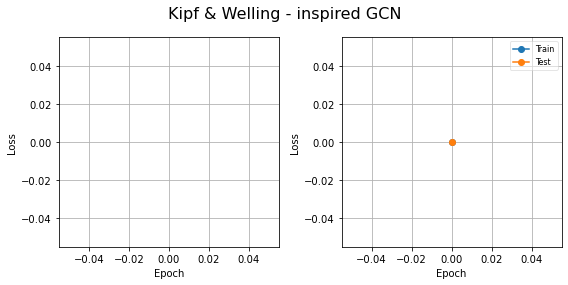

(200, 2)

In [216]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
plt.suptitle("Kipf & Welling - inspired GCN", fontsize=16)
speclib.plot_one_curve(axes[0], losses, xlabel='Epoch', ylabel='Loss', style='-', title='')

y = np.asarray([v for k,v in accuracy_count.items()]).T  # shape: [N, 2]  
x = np.linspace(0, y.shape[0]*1, y.shape[0])
speclib.plot_multi_curves(axes[1], x[::200], y[::200,:], xlabel='Epoch', ylabel='Loss', title='', labels=['Train', 'Test'])

plt.tight_layout()
plt.show()
y.shape

# Decoupling attributes/labels from structure
The question is: how important is the structural information? To determine that, we keep the graph fixed, but shuffle the labels across the graph nodes:
The number of each label will remain the same, but the labels, together with the attributes, will migrate to different nodes. 
Therefore, the edge connections  are no longer related to the edges. In that situation, one expects labelling accuracy to go down. 

This is accomplished by reshuffling the rows of `graph.node_metadata`. So first create a node permutation. 

In [40]:
perm_nodes = torch.randperm(G.nb_nodes)
H0 = torch.tensor(G.node_metadata)
H0 = H0[perm_nodes]
print("H0.shape: ", H0.shape)

H0.shape:  torch.Size([34, 16])


<ipython-input-40-216b79595830>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  H0 = torch.tensor(G.node_metadata)


In [41]:
# A, H, H0, Y, W, mask = model_setup(G, frac_train=.2, H0=H0) 
print(model)
params = model.parameters()
for p in params:
    torch.nn.init.xavier_uniform_(p)
      
# initiali
index = torch.where(mask == 0, True, False)
# loss, accuracy_count = train(A, H, H0, Y, W, mask, nb_epochs=5501, activation="sigmoid", lr=1.e-4)
losses, accuracy_count = new_train(G, model, mask, loss_fn, optimizer, nb_epochs=300)

myGCN(
  (gcn1): GCNConv(
    (relu1): ReLU()
    (relu2): ReLU()
  )
  (linear): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


ValueError: Fan in and fan out can not be computed for tensor with fewer than 2 dimensions

In [44]:
losses

[14.312211990356445,
 14.26537799835205,
 14.21847915649414,
 14.17198657989502,
 14.124680519104004,
 14.071856498718262,
 14.014084815979004,
 13.95553970336914,
 13.894633293151855,
 13.829692840576172,
 13.762678146362305,
 13.696051597595215,
 13.633671760559082,
 13.572019577026367,
 13.510711669921875,
 13.448821067810059,
 13.386198997497559,
 13.323055267333984,
 13.259425163269043,
 13.194624900817871,
 13.127300262451172,
 13.057137489318848,
 12.98516845703125,
 12.911811828613281,
 12.834980010986328,
 12.766751289367676,
 12.691020965576172,
 12.609585762023926,
 12.52700424194336,
 12.455761909484863,
 12.384958267211914,
 12.312151908874512,
 12.23721981048584,
 12.16221809387207,
 12.08516788482666,
 12.005248069763184,
 11.922565460205078,
 11.8375244140625,
 11.749674797058105,
 11.658825874328613,
 11.567281723022461,
 11.477706909179688,
 11.383225440979004,
 11.289436340332031,
 11.198917388916016,
 11.10572624206543,
 11.008654594421387,
 10.906889915466309,
 10.

gordon


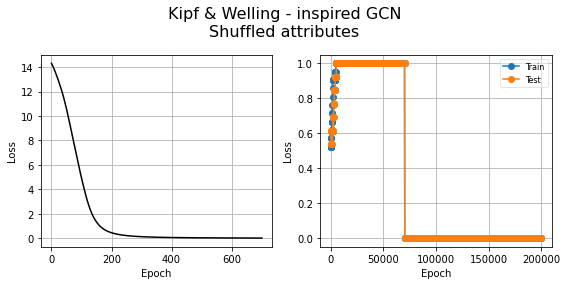

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
plt.suptitle("Kipf & Welling - inspired GCN\nShuffled attributes", fontsize=16)
speclib.plot_one_curve(axes[0], losses, xlabel='Epoch', ylabel='Loss', style='-', title='')

y = np.asarray([v for k,v in accuracy_count.items()]).T  # shape: [N, 2]  
x = np.linspace(0, y.shape[0]*100, y.shape[0])
speclib.plot_multi_curves(axes[1], x, y, xlabel='Epoch', ylabel='Loss', title='', labels=['Train', 'Test'])

plt.tight_layout()
plt.show()

## Observations
* When I shuffled the features to decorrelate them with respect to the labels, the loss function decreases rather differently than before. WHY? 